# USDRUB minute intraday data analysis

# Part I
## ARIMA
This is an attempt to explore USDRUB minute data using a classical time series model ARMA and its modifications. Even though this data might not be very suitable for autoregressive models due to the unmet assumptions, I still need a benchmark to continue future data exploration.

Some functions are taken from pmdarima examples on git: https://github.com/alkaline-ml/pmdarima/blob/master/examples/stock_market_example.ipynb

*Might be necessary:* `pip install pmdarima`, `pip install xgboost`

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import pmdarima as pm

### Data origin

USDRUB data is from Bloomberg. Each day data starts from 10:00 Moscow time. I randomly chose the date 2020-11-05 and cut first 500 observations. Hence, the first observation is 2020-11-05 10:00:00 and the last observation is 2020-11-05 18:19:00. This time interval also makes practical sense because active trading usually starts at 10am and finishes around 6pm, which is the end of working day in Russia.

In [2]:
df = pd.read_csv('usdrub_2020-11-05_18*19.csv')
df['Date'] = pd.to_datetime(df['Date'])
df.head()

,Date,Open,High,Low,Close,RUB MICE Curncy - Volume
0,2020-11-05 10:00:00,78.0975,78.5400,78.0525,78.5400,58639000.0
1,2020-11-05 10:01:00,78.5375,78.5475,78.2800,78.2850,34460000.0
2,2020-11-05 10:02:00,78.2800,78.3500,78.2675,78.3000,20053000.0
3,2020-11-05 10:03:00,78.2800,78.3775,78.2500,78.3425,20648000.0
4,2020-11-05 10:04:00,78.3450,78.4000,78.3275,78.3625,13089000.0


### Split the data

I'll use 80% of the sample as training data, order is preserved.

In [3]:
df_size = len(df)

train_len = int(df_size*0.8)
train_data, test_data = df[:train_len], df[train_len:]

y_train = train_data['Close'].values
y_test = test_data['Close'].values

print('Train size:', train_len)
print('Test size', df_size - train_len)

Train size: 400
Test size 100


### Preliminary analysis

A lag plot can provide clues about the underlying structure of the data. A linear shape to the plot might suggest that an autoregressive model is probably a better choice.

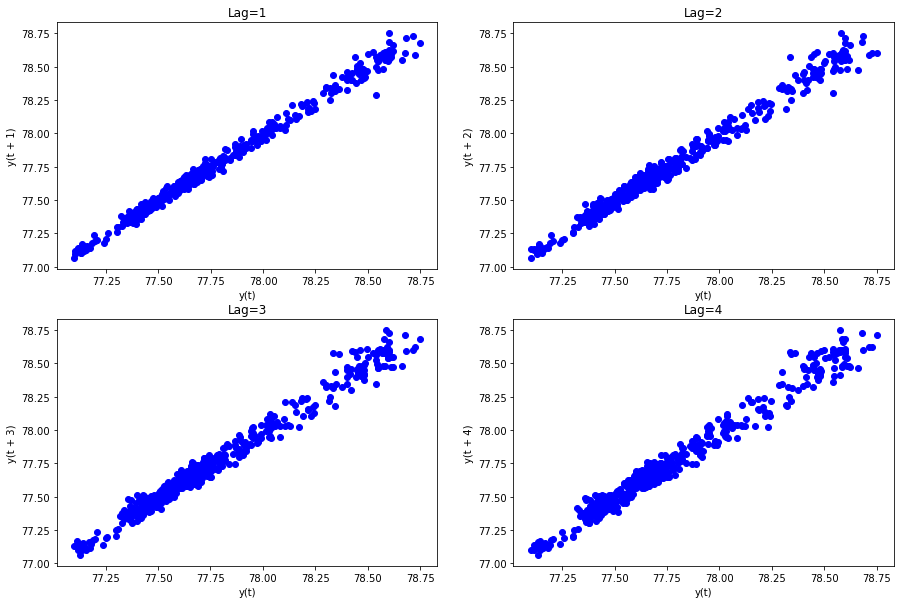

In [4]:
from pandas.plotting import lag_plot

fig, axes = plt.subplots(2, 2, figsize=(15, 10))
plt.title('Autocorrelation plot')

ax_idcs = [
    (0, 0),
    (0, 1),
    (1, 0),
    (1, 1)
]

for lag, ax_coords in enumerate(ax_idcs, 1):
    ax_row, ax_col = ax_coords
    axis = axes[ax_row][ax_col]
    lag_plot(df['Close'], lag=lag, ax=axis, c='b')
    axis.set_title(f"Lag={lag}")
    
plt.show()

I checked 4 lags, they look fairly linear, so auto-regressive model might be a good choice. I'll allow the `auto_arima` to select the lag term.

### Estimating the differencing term

We can estimate the best lag term with several statistical tests: Kwiatkowski–Phillips–Schmidt–Shin (KPSS) test, augmented Dickey–Fuller (ADF) test and Phillips–Perron (PP) test.  
All three of them are unit root tests of stationarity used in order to test the stationarity of the time-series.

H0: observable time series is stationary  
H1: otherwise

`pmdarima` allows to estimate number of differences necessary to make the series stationary (parameter **d**). I will search until maximun **d** of 10.

In [5]:
from pmdarima.arima import ndiffs

kpss_diffs = ndiffs(y_train, alpha=0.05, test='kpss', max_d=10)
adf_diffs = ndiffs(y_train, alpha=0.05, test='adf', max_d=10)
pp_diffs = ndiffs(y_train, alpha=0.05, test='pp', max_d=10)

print('KPSS estimated differencing term:', kpss_diffs)
print('ADF estimated differencing term:', adf_diffs)
print('PP estimated differencing term:', pp_diffs)

n_diffs = max(kpss_diffs, adf_diffs, pp_diffs)

KPSS estimated differencing term: 1
ADF estimated differencing term: 1
PP estimated differencing term: 1


All three tests indicate **d** = 1 using 5% significance level. So, there is statistical evidence that the train sample is stationary with **d** = 1 given alpha 5%. Hence, further in `auto_arima` I will use **d** = 1.

Then we can look at Auto Correlation Function (ACF) and Partial Auto Correlation Function (PACF) plots in order to have an understanding what AR and/or MA processes might be present in the data.

Here are ACF and PACF before any differencing is performed:

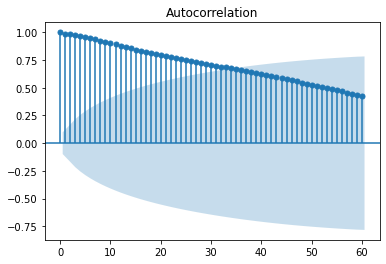

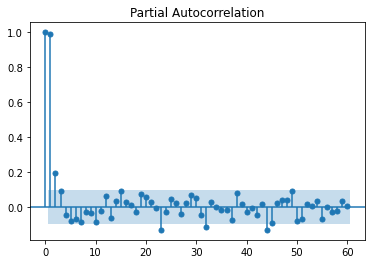

In [6]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

plot_acf(y_train, lags=60);
plot_pacf(y_train, lags=60);

Here are ACF and PACF after a time series has been stationarized by differencing:

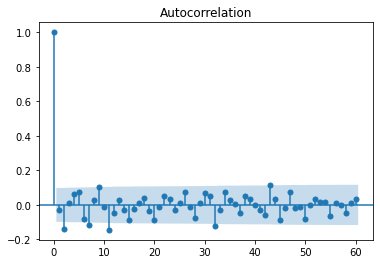

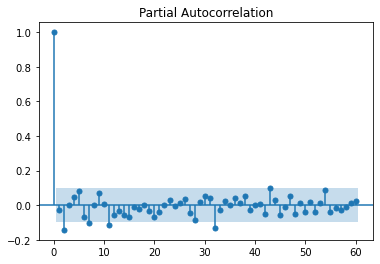

In [7]:
plot_acf(df['Close'].diff()[1:400], lags=60);
plot_pacf(df['Close'].diff()[1:400], lags=60);

ACF plot shows that attention ahould be paid to the 2d lag, probably 7th, 11th and 32th lags.  
PACF captures correlations of residuals and the time series lags. From PACF plot we see that the lag 2 might be significant and some other lags similar to ACF. So, I plan to check for some higher-order lags in `auto_arima`.

Then I want to plot some seasonal decompositions based on my expectations (30Min and 1H periods).

In [8]:
import statsmodels.tsa.api as smt

def seasonal_decompose_plot(period):
    
    decomposition = smt.seasonal_decompose(df['Close'], period=period)
    trend = decomposition.trend
    seasonal = decomposition.seasonal
    residual = decomposition.resid
    fig, ax = plt.subplots(nrows=4, ncols=1, sharex=True, sharey=False, figsize=(20, 7))
    ax[0].plot(df['Close'])
    ax[0].set_title('Original')
    ax[0].grid(True)
    ax[1].plot(trend)
    ax[1].set_title('Trend')
    ax[1].grid(True)
    ax[2].plot(seasonal)
    ax[2].set_title('Seasonality')
    ax[2].grid(True)
    ax[3].plot(residual)
    ax[3].set_title('Residuals')
    ax[3].grid(True)

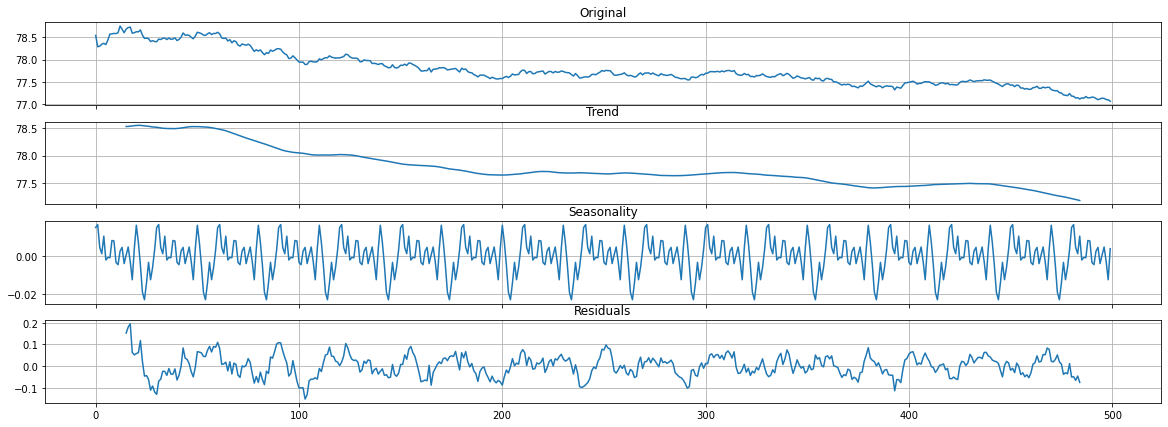

In [9]:
seasonal_decompose_plot(30)

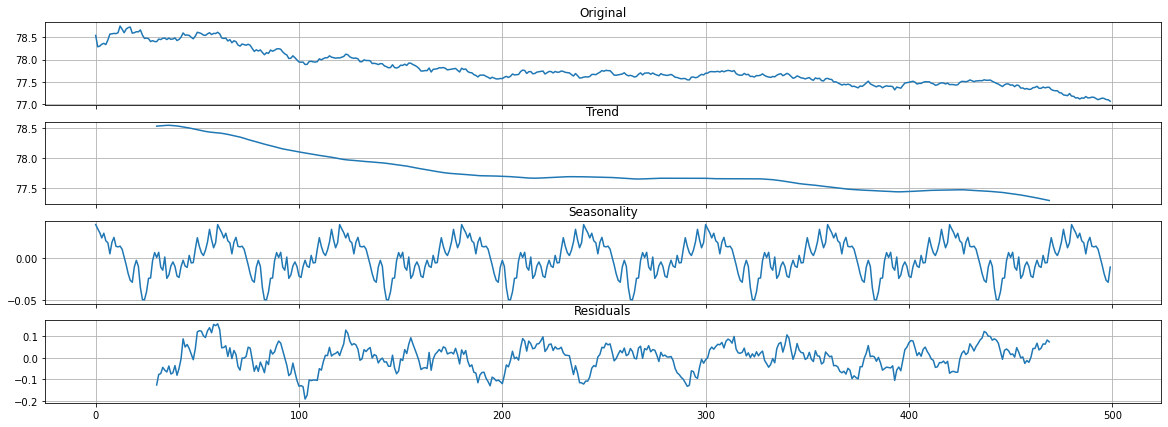

In [10]:
seasonal_decompose_plot(60)

Clearly, a trend can be seen in data. However, I don't see any strong seasonal patterns. Residuals from 30Min and 1H seasonal components don't seem to look as random as they are supposed to be.

Then I use `auto_arima` to fit a model on the data. **d** is set to n_diffs, which is 1.
Allowing ARIMA models explore various values of **p** and **q**.

First, comes search with standard **p** and **q**:

In [11]:
auto = pm.auto_arima(y_train, d=n_diffs, seasonal=False, stepwise=True,
                     suppress_warnings=True, error_action="ignore",
                     max_order=None, trace=True)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-1483.674, Time=0.75 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-1476.976, Time=0.08 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-1475.345, Time=0.10 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-1475.516, Time=0.19 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-1477.013, Time=0.03 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-1479.769, Time=0.44 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-1480.539, Time=0.21 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=-1492.006, Time=0.74 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-1478.541, Time=0.51 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=-1477.961, Time=0.81 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=-1487.526, Time=0.60 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=-1492.815, Time=0.68 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=-1478.749, Time=0.32 sec
 ARIMA(2,1,4)(0,0,0)[0] intercept   : AIC=-1485.639, Time=0.89 sec
 ARIMA(1,1,4)(0,0,0

And then with high-order **p** and **q**:

In [12]:
auto2 = pm.auto_arima(y_train, d=n_diffs, seasonal=False, stepwise=True,
                     suppress_warnings=True, error_action="ignore", max_q=20, max_p=20,
                     max_order=None, trace=True, start_p=20, start_q=20)

Performing stepwise search to minimize aic
 ARIMA(20,1,20)(0,0,0)[0] intercept   : AIC=-1444.676, Time=8.90 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-1476.976, Time=0.08 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-1475.345, Time=0.10 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-1475.516, Time=0.20 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-1477.013, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-1478.258, Time=0.52 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-1480.539, Time=0.22 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-1482.536, Time=0.28 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-1480.539, Time=0.27 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-1478.541, Time=0.50 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-1481.845, Time=0.20 sec

Best model:  ARIMA(2,1,0)(0,0,0)[0] intercept
Total fit time: 11.320 seconds


ARIMA(2,1,2) has lower AIC, so I will use it as the main. model.

In [13]:
print('The best model is rather simple: ARIMA', auto.order)

The best model is rather simple: ARIMA (2, 1, 2)


In [14]:
# define function to plot forecasts
# the code below is taken from pmdarima examples on git

def plot_forecasts(forecasts, confidence_intervals):

    fig, axes = plt.subplots(2, 1, figsize=(12, 12))

    # --------------------- Actual vs. Predicted --------------------------
    axes[0].plot(y_train, color='blue', label='Training Data')
    axes[0].plot(test_data.index, forecasts, color='green', marker='o',
                 label='Predicted Price')

    axes[0].plot(test_data.index, y_test, color='red', label='Actual Price')
    axes[0].set_title('USDRUB Prediction')
    axes[0].set_xlabel('Dates')
    axes[0].set_ylabel('Prices')
    axes[0].legend()


    # ------------------ Predicted with confidence intervals ----------------
    axes[1].plot(y_train, color='blue', label='Training Data')
    axes[1].plot(test_data.index, forecasts, color='green',
                 label='Predicted Price')

    axes[1].set_title('USDRUB Predictions & Confidence Intervals')
    axes[1].set_xlabel('Dates')
    axes[1].set_ylabel('Prices')

    conf_int = np.asarray(confidence_intervals)
    axes[1].fill_between(test_data.index,
                         conf_int[:, 0], conf_int[:, 1],
                         alpha=0.9, color='orange',
                         label='Confidence Intervals')
    axes[1].legend()
    plt.show()

### Multiple Step Ahead Forecast

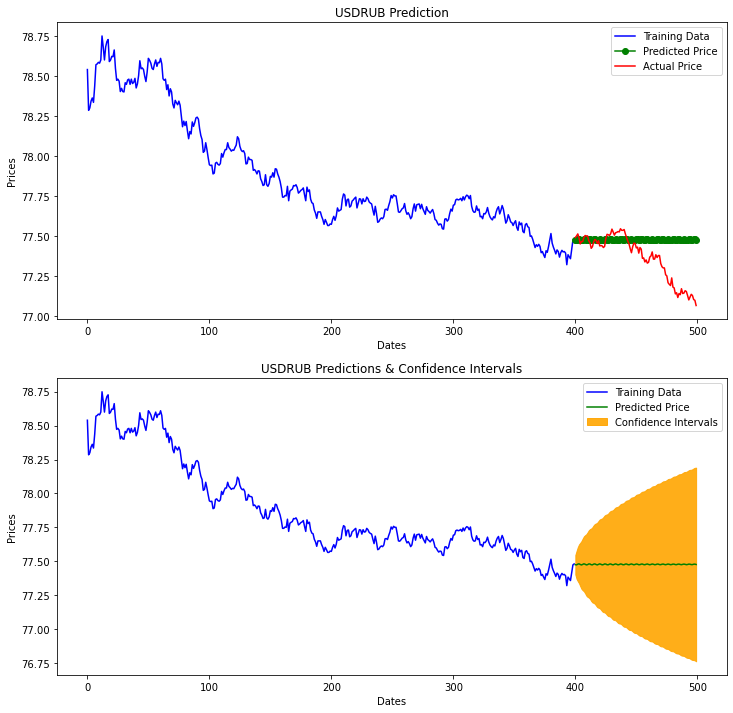

In [15]:
multiple_step_ahead = auto.predict(n_periods=len(y_test), return_conf_int=True)
forecasts_m, confidence_intervals_m = multiple_step_ahead
plot_forecasts(forecasts_m, confidence_intervals_m)

Unfortunately, multiple step ahead forecast yields almost constant prediction and is not informative.

### One Step Ahead Forecast

Mean squared error: 0.0005589388610262922
SMAPE: 0.024385681345975203


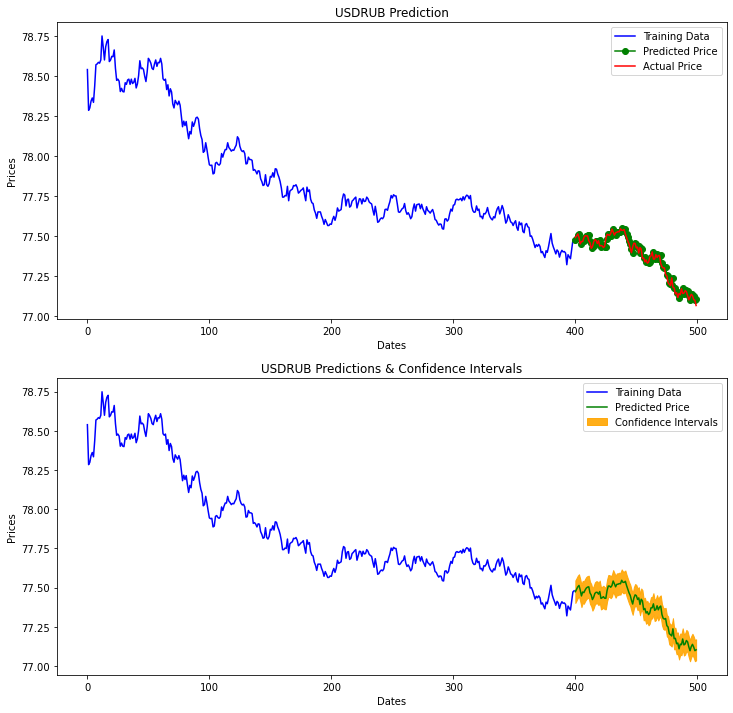

In [16]:
# the code below is taken from pmdarima examples on git

from sklearn.metrics import mean_squared_error
from pmdarima.metrics import smape

model = auto

def forecast_one_step():
    fc, conf_int = model.predict(n_periods=1, return_conf_int=True)
    return (
        fc.tolist()[0],
        np.asarray(conf_int).tolist()[0])

forecasts = []
confidence_intervals = []

for idx, new_ob in enumerate(y_test):
    fc, conf = forecast_one_step()
    forecasts.append(fc)
    confidence_intervals.append(conf)

    # Updates the existing model with a small number of MLE steps
    model.update(new_ob)
    print(idx+1, end='\r')

print('Mean squared error:', mean_squared_error(y_test, forecasts))
print('SMAPE:', smape(y_test, forecasts))

plot_forecasts(forecasts, confidence_intervals)

### Conclusion

Confidence interval is rather wide. At first sight it may seem that forecast is surprisingly good in terms of general direction and precision, even MSE metric suggests so. However, if we look closely at the chart of predicted and actual prices, we see that ARIMA (2,1,2) is too simple and predicts the next price to be almost the same as previous and given the current data, this is not very accurate prediction. Other models with AR and/or MA were not consedered to be the best by AIC criterion.

RMSE: 0.023641887848187847
Max difference between actual and predicted: 0.05739625902094758
Min difference between actual and predicted: 0.0001629245930274692


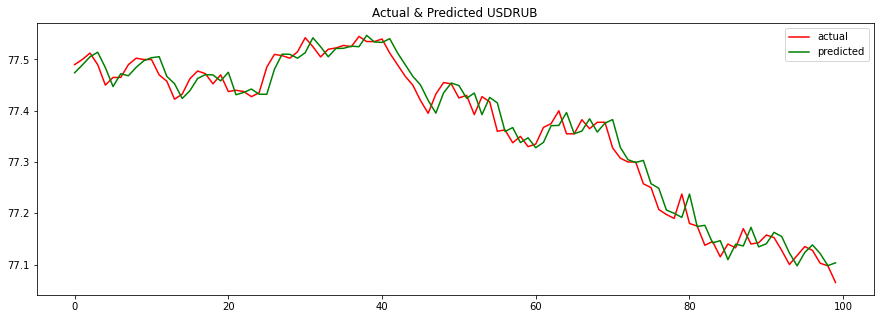

In [17]:
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
ax.plot(range(len(y_test)), y_test, label='actual', c='r')
ax.plot(range(len(y_test)), forecasts, label='predicted', c='g')
ax.set_title('Actual & Predicted USDRUB')
ax.legend()
print('RMSE:', mean_squared_error(y_test, forecasts)**(1/2))

abs_diff = abs(y_test - np.array(forecasts))
print('Max difference between actual and predicted:', np.max(abs_diff))
print('Min difference between actual and predicted:', np.min(abs_diff))
plt.show()

Root Mean Squared Error suggests that on average the difference between actual and predicted USDRUB is about 2 kopecks. Maximum difference between actual and predicted USDRUB is almost 6 kopecks. Though, the minimal one is negligible.

# Part II
## Smth else

To use ML models some additional features from data can be extracted.

In [61]:
data = pd.DataFrame(df.Close.copy())
data.columns = ['y']
data['Volume'] = df['RUB MICE Curncy - Volume']
data.index = df['Date']

# Adding the lag of the target variable from 1 steps back up to 10
for i in range(1, 10):
    data["lag_{}".format(i)] = data.y.shift(i)

# time features
data.index = pd.to_datetime(data.index)
data['hour'] = data.index.hour
data['minute'] = data.index.minute
data.head()

,y,Volume,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,hour,minute
Date,,,,,,,,,,,,,
2020-11-05 10:00:00,78.5400,58639000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10,0
2020-11-05 10:01:00,78.2850,34460000.0,78.5400,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10,1
2020-11-05 10:02:00,78.3000,20053000.0,78.2850,78.540,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10,2
2020-11-05 10:03:00,78.3425,20648000.0,78.3000,78.285,78.540,NaN,NaN,NaN,NaN,NaN,NaN,10,3
2020-11-05 10:04:00,78.3625,13089000.0,78.3425,78.300,78.285,78.54,NaN,NaN,NaN,NaN,NaN,10,4


I will sacrifice beginning of the day in order to introduce more lags. The test set remains the same as for ARIMA model.

In [62]:
y = data.dropna().y
X = data.dropna().drop(['y'], axis=1)

test_start_idx = len(y) - (df_size - train_len)

X_train, X_test = X[:test_start_idx], X[test_start_idx:]
y_train, y_test = y[:test_start_idx], y[test_start_idx:]

print('Train size:', test_start_idx)
print('Test size', df_size - train_len)

Train size: 391
Test size 100


We have different scale of features thus we transform them into same scale.

In [63]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [67]:
from xgboost import XGBRegressor 

xgb = XGBRegressor()
xgb.fit(X_train_scaled, y_train)

XGBoostError: 
XGBoost Library (libxgboost.dylib) could not be loaded.
Likely causes:
  * OpenMP runtime is not installed
    - vcomp140.dll or libgomp-1.dll for Windows
    - libomp.dylib for Mac OSX
    - libgomp.so for Linux and other UNIX-like OSes
    Mac OSX users: Run `brew install libomp` to install OpenMP runtime.

  * You are running 32-bit Python on a 64-bit OS

Error message(s): ['dlopen(/opt/anaconda3/lib/python3.8/site-packages/xgboost/lib/libxgboost.dylib, 6): Library not loaded: /usr/local/opt/libomp/lib/libomp.dylib\n  Referenced from: /opt/anaconda3/lib/python3.8/site-packages/xgboost/lib/libxgboost.dylib\n  Reason: image not found']
